In [1]:
import numpy as np
from numpy import random
import scipy as sp
import pandas as pd

# import scanpy for dimensionality reduction and plotting
import anndata as ad
from scanpy.tl import diffmap
from scanpy.tl import pca
from scanpy import pp

# set viridis as the default color map
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
mpl.rcParams['image.cmap'] = 'viridis'

# import PROSSTT for the simulation
from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut
from prosstt import count_model as cmod

# import some plotting help
from comparison_functions import *

In [2]:
# import rpy2 in order to interface with R
import rpy2
%load_ext rpy2.ipython

# limSolve from R in order to make simple polynomial fits
# MERLoT for some plotting functions
%R library(limSolve)
%R library(merlot)

array(['merlot', 'limSolve', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

set random seed for reproducibility

In [3]:
rseed = 42
np.random.seed(rseed)

read the processed embedded tree, as produced by the authors using MERLoT and plot it so that we get an idea about the topology:

[[1]]
 [1]  3 90 12 38 29 32 45 51 40 10 13  6

[[2]]
 [1]   2  79  78  77  27  31  88  70  92  69  89 100  94  93  73  72  85  68  63
[20]  60  23  65  61  17  24  15  36  42  43  57  53  54  50  18  86  16  56  64
[39]  59   6

[[3]]
[1] 6 5

[[4]]
 [1]  1 99 98 83 46 71 76 75 33 35 67 91 81 80 97 66 48 58 47 39 62 22 26  8 19
[26]  9  5

[[5]]
 [1]  4 84 20 96 95 55 74 25 41 44 82 49 87 28 37 34 30 52 11 21 14  7  5



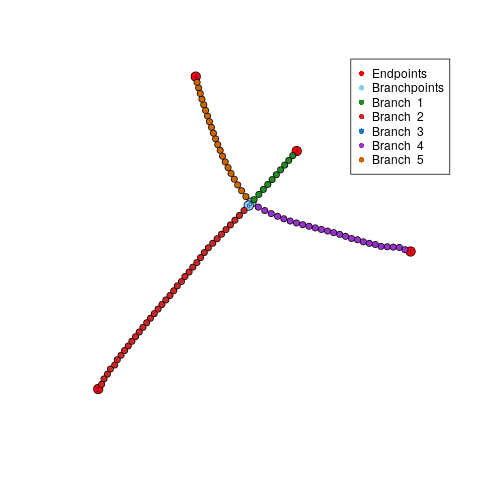

In [4]:
%%R

emb <- readRDS("~/Documents/data/axolotl/EmbeddedTree_NEnd4_top50ClustBl-topMatMarker_OnlyBlastema.RDS")
plot_flattened_tree(emb)
emb$Branches

read the raw data that was used to find the lineage tree:

In [5]:
X = %R emb$CellCoords
N, G = X.shape

The topology is a double bifurcation: ((3-6, 2-6)6-5, 5-1)5-4. We can identify the branches by the expression of marker genes:

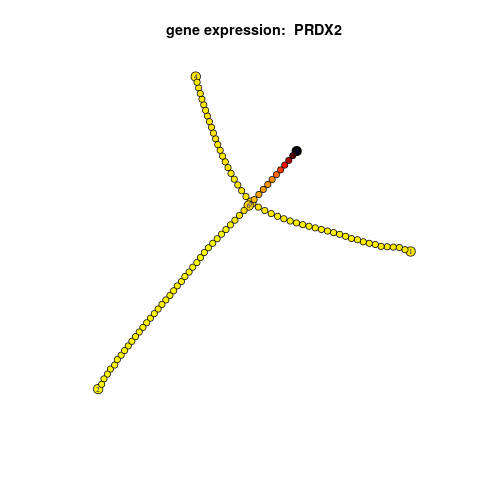

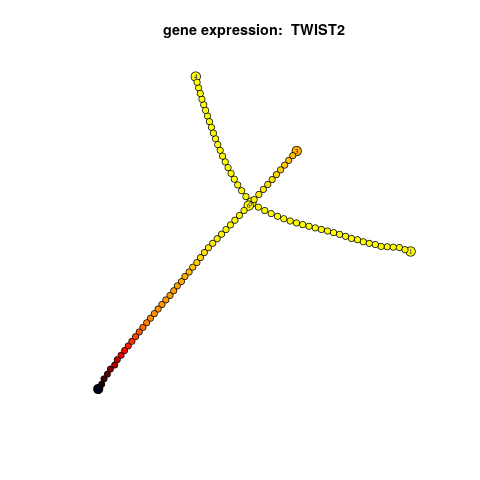

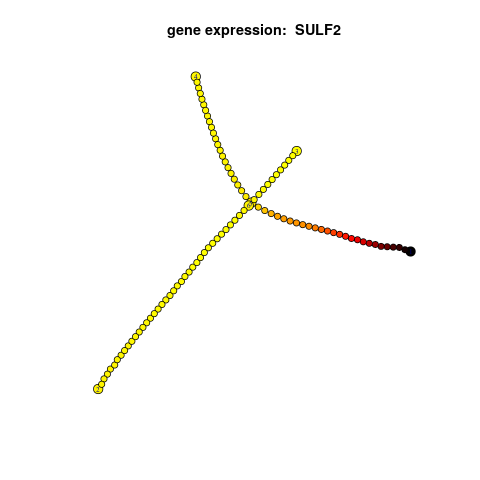

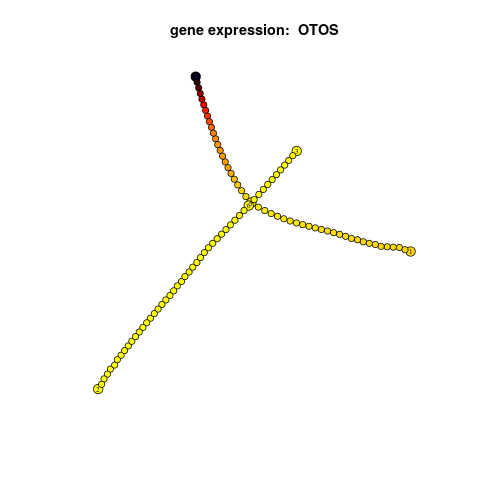

In [6]:
%%R

plot_flattened_tree_gene_expression(emb, "PRDX2") # progenitors
plot_flattened_tree_gene_expression(emb, "TWIST2") # non-skeletal
plot_flattened_tree_gene_expression(emb, "SULF2") # bone
plot_flattened_tree_gene_expression(emb, "OTOS") # cartilage

1) 3-6 is the progenitor branch  
2) 2-6 is the non-skeletal branch  
3) 5-6 is the intermediate branch  
4) 1-5 is the bone branch  
5) 4-5 is the cartilage branch  

which gives us the following topology:

In [7]:
branches = ["progenitor", "nonskeletal", "intermediate", "cartilage", "bone"]
topology = [["progenitor", "nonskeletal"],
            ["progenitor", "intermediate"],
            ["intermediate", "bone"],
            ["intermediate", "cartilage"]]

The length of each branch is its pseudotime:

In [8]:
%R unlist(lapply(emb$Branches, length))

array([12, 40,  2, 27, 23], dtype=int32)

this can be translated to PROSSTT terms:

In [9]:
time = {"progenitor": 12, "nonskeletal": 40, "intermediate": 2, "bone": 27, "cartilage": 23}

this information is enough to initialize the tree to be simulated. We will set modules to 0 since we are going to take information about the average expression directly from the tree:

In [10]:
t = tree.Tree(topology=topology, G=G, time=time, num_branches=len(branches), branch_points=2, modules=0)

Now it is time to extract the change in average expression, which can be found on the nodes of the embedded tree.

In [11]:
%%R
mean_exp <- list()

for (i in 1:5) {
    b <- emb$Branches[[i]]
    # PROSSTT doesn't like non-positive values, so replace these
    emb$Nodes[b, ][emb$Nodes[b, ] <= 0] <- 1e-7
    mean_exp[[i]] <- emb$Nodes[b, ]
}

In [12]:
progenitor = %R mean_exp[[1]]
nonskeletal = %R mean_exp[[2]]
intermediate = %R mean_exp[[3]]
bone = %R mean_exp[[4]]
cartilage = %R mean_exp[[5]]

In [13]:
t.add_genes({"progenitor": np.array(progenitor),
            "nonskeletal": np.array(nonskeletal),
            "intermediate": np.array(intermediate),
            "bone": np.array(bone),
            "cartilage": np.array(cartilage)})

We also need to know how the cells are distributed along the tree so that we can simulate appropriately. This information can be found by counting the number of cells mapped to every tree node.

In [14]:
%%R
tree_density <- rep(0, 100)
tabled <- table(emb$Cells2TreeNodes[,2])
tree_density[as.integer(names(tabled))] <- tabled

cells_per_node <- list()
for (i in 1:5) {
  b <- emb$Branches[[i]]
  cells_per_node[[i]] <- tree_density[b]
}

we can translate this to density by dividing it by the total number of cells mapped to a node:

In [15]:
progenitor_density = %R cells_per_node[[1]]
nonskeletal_density = %R cells_per_node[[2]]
intermediate_density = %R cells_per_node[[3]]
bone_density = %R cells_per_node[[4]]
cartilage_density = %R cells_per_node[[5]]

total_density = np.sum(bone_density) +     \
                np.sum(cartilage_density) + \
                np.sum(progenitor_density) + \
                np.sum(nonskeletal_density) + \
                np.sum(intermediate_density)

tree_density = {"progenitor": progenitor_density / total_density,
                "nonskeletal": nonskeletal_density / total_density,
                "intermediate": intermediate_density / total_density,
                "bone": bone_density / total_density,
                "cartilage": cartilage_density / total_density}

since the tree density now sums up to 1 we can safely set it:

In [16]:
t.set_density(tree_density)

In order to accurately simulate gene expression, we need to know the variance hyperparameters for the expression of every gene. PROSSTT uses a model where the variance $\sigma_g^2$ depends on the mean by $\alpha_g \mu_g^2 + \beta_g \mu_g$.

To get a quick estimate for the hyperparameters we will use the local clustering provided by the tree nodes to get values of $\mu_g, \sigma_g^2$ at different times and fit a degree-2 polynomial by least squares. We constrain the solution by asking that $\alpha_g > 0$ and $\beta_g > 1$, which we require for the negative binomial.

Just as before, instead of exact 0 we use a sufficiently small positive number to avoid numerical underflow in later steps.

In [17]:
%%R

# collect means and variance for all genes and all tree nodes
means <- array(0, c(100, dim(emb$CellCoords)[2]))
vars <- array(0, c(100, dim(emb$CellCoords)[2]))

for(n in 1:100) {
  node_cells <- emb$Cells2TreeNodes[,1][emb$Cells2TreeNodes[,2] == n]
  means[n,] <- apply(emb$CellCoords[node_cells, ], 2, mean)
  vars[n,] <- apply(emb$CellCoords[node_cells, ], 2, var)
}

genes <- dim(emb$CellCoords)[2]
alphas <- rep(0, genes)
betas <- rep(0, genes)

# perform fits
for (g in 1:genes) {
  m <- means[, g]
  s <- vars[, g]
  A <- cbind(rep(0, length(m)), m, m^2)
  b <- s #rep(1, length(m))
  G <- matrix(nrow=2, ncol=3, byrow = TRUE, data = c(0, 0, 1, 0, 1, 0))
  h <- c(1e-7, 1+1e-7)
  constrained_model <- tryCatch(
    {
      lsei(A = A, B = b, G = G, H = h, type=2)
    },
    error=function(cond) {
      # it may happen that we get numerical overflow for
      # particularly large values. In that case, rescale
      # and re-fit.
      message(cond)
      message("\nrescaling...")
      m <- means[, g] / 1000
      s <- vars[, g] / 1000
      A <- cbind(rep(0, length(m)), m, m^2)
      b <- s #rep(1, length(m))
      lsei(A = A, B = b, G = G, H = h, type=2)
    },
    finally={}
  )
  
  alphas[g] <- constrained_model$X[3]
  betas[g] <- constrained_model$X[2]
}

/home/soedinglaptop/miniconda3/envs/py37/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: constraints are inconsistent, no solution!
  warnings.warn(x, RRuntimeWarning)
/home/soedinglaptop/miniconda3/envs/py37/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
rescaling...

  warnings.warn(x, RRuntimeWarning)


In [18]:
alphas = %R alphas
betas = %R betas

Calculate the average relative cell size of the original data. We will need its variance to accurately simulate cell size from PROSSTT.

In [19]:
scalings = np.sum(X, axis=1)
scalings = scalings / np.mean(scalings)

In [20]:
X1, labs1, brns1, scalings1 = sim.sample_density(t, N,
                                                 alpha=alphas, beta=betas,
                                                 scale_mean=0, scale_v=np.var(scalings))

# map branches to numbers so that coloring is easier
indices1 = np.zeros(N, dtype=int)
for i, b in enumerate(t.branches):
    indices1[np.where(brns1 == b)] = i

Instead of the "true" scalings we are going to use the empirical ones to make the simulated and the original data a bit more comparable

In [21]:
scalings1 = np.sum(X1, axis=1)
scalings1 = scalings1 / np.mean(scalings1)

Compare real count distribution to the simulated one:

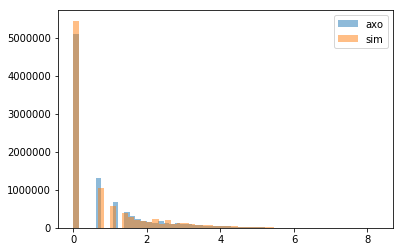

In [22]:
fig, ax = plt.subplots()
h = ax.hist(np.log(X.flatten()+1), bins=50, label="axo", alpha=0.5)
h = ax.hist(np.log(X1.flatten()+1), bins=50, label="sim", alpha=0.5)
l = ax.legend()

normalize by library size

read the branch assignments of the MERLoT tree so that we can compare the embeddings

In [23]:
merlot_branches = %R emb$Cells2Branches

In [24]:
together = np.concatenate((X, X1))
original = ["original"] * N
simulated = ["simulated"] * N
origin = np.concatenate((original, simulated))

data = ad.AnnData(together)
pp.neighbors(data, use_rep="X")
diffmap(data)
dm = data.obsm["X_diffmap"]

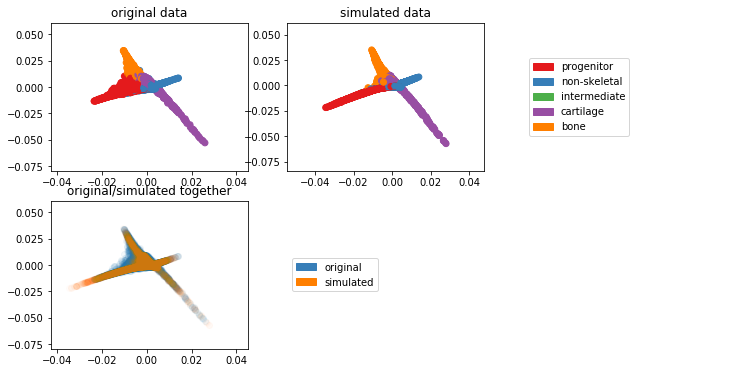

In [25]:
plot_overlap(dm, origin, indices1, merlot_branches)